## Cardio XGBoost

In [1]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from math import sqrt  # for root mean-squared error calculation
import matplotlib
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #scale data

from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import binarize
from sklearn.metrics import precision_recall_curve

from xgboost import XGBClassifier

## Defined functions

In [2]:
# define a function to return model metrics for evaluation

def model_metrics(y_known, y_pred):
    y_test = y_known
    y_pred_class = y_pred
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    class_error = 1 - metrics.accuracy_score(y_test, y_pred_class)
    sensitivity = metrics.recall_score(y_test, y_pred_class)
    specificity = TN / (TN + FP)
    false_positive_rate = FP / float(TN + FP)
    precision = TP / float(TP + FP)
    f1_score = metrics.f1_score(y_test, y_pred_class)
#    F1 = 2*precision*sensitivity/(precision + sensitivity)
    print('The model metrics are:',
         '\naccuracy:', accuracy,
         '\nclassification error:', class_error,
         '\nsensitivity:', sensitivity,
         '\nspecificity:', specificity,
         '\nfalse positive rate:', false_positive_rate,
         '\nprecision:', precision,
          '\nF1 score:', f1_score,
#          '\nF1 by hand:', F1,
         '\nconfusion matrix:')
    return(confusion)

In [3]:
# define a function that accepts a threshold and 
# prints sensitivity and specificity

def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [4]:
# define a function that accepts the fpr and tpr values 
# from the roc_curve function and plot the ROC curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for response')

In [5]:
# define a function that accepts the recall and precision values 
# from the precision_recall_curve function and plot the PR curve

def plot_pr_curve(recall, precision, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
#    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve for response')

## Import data set and prepare for analysis

In [6]:
# initial work with the smaller data set
X_test = pd.read_csv('cardio_x_test.csv', sep = ',', encoding = 'unicode_escape')  
X_train = pd.read_csv('cardio_x_train.csv', sep = ',', encoding = 'unicode_escape')  
y_test = pd.read_csv('cardio_y_test.csv', sep = ',', encoding = 'unicode_escape')  
y_train = pd.read_csv('cardio_y_train.csv', sep = ',', encoding = 'unicode_escape')
# examine the shape of original input data
print('The shape of the X test set is: ', X_test.shape)
print('The shape of the X train set is: ',X_train.shape)
print('The shape of the Y test set is: ',y_test.shape)
print('The shape of the Y train set is: ',y_train.shape)

The shape of the X test set is:  (13750, 24)
The shape of the X train set is:  (54997, 24)
The shape of the Y test set is:  (13750, 2)
The shape of the Y train set is:  (54997, 2)


In [7]:
#drop unnecessary columns for model
X_train = X_train.drop(['Unnamed: 0', 'id', 'age_days', 'LATITUDE',
                 'LONGITUDE','ZIP','FACILITY_NAME','ADDRESS',
                 'CITY','STATE','DESCRIPTION','FACILITY_TYPE' ], axis=1)
X_test = X_test.drop(['Unnamed: 0', 'id', 'age_days', 'LATITUDE',
                 'LONGITUDE','ZIP','FACILITY_NAME','ADDRESS',
                 'CITY','STATE','DESCRIPTION','FACILITY_TYPE' ], axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_test = y_test.drop(['Unnamed: 0'], axis=1)    


In [8]:
#rename the column in the target train and test sets
y_train = y_train.rename(columns={"x": "cardio"})
y_test = y_test.rename(columns={"x": "cardio"})

In [9]:
#total number of NaN values in each column
print('The total number of NaN values in the X test set is:\n', X_test.isnull().sum())
print('The total number of NaN values in the X train set is:\n',X_train.isnull().sum())
print('The total number of NaN values in the Y test set is:\n',y_test.isnull().sum())
print('The total number of NaN values in the Y train set is:\n',y_train.isnull().sum())


The total number of NaN values in the X test set is:
 age_years      0
gender         0
height_cm      0
weight_kg      0
BMI            0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
dtype: int64
The total number of NaN values in the X train set is:
 age_years      0
gender         0
height_cm      0
weight_kg      0
BMI            0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
dtype: int64
The total number of NaN values in the Y test set is:
 cardio    0
dtype: int64
The total number of NaN values in the Y train set is:
 cardio    0
dtype: int64


In [10]:
# mapping function to convert text female/male to integer 1/2
convert_to_binary = {'female' : 1, 'male' : 2}

# define binary variable for gender
X_train['gender'] = X_train['gender'].map(convert_to_binary)
X_test['gender'] = X_test['gender'].map(convert_to_binary)

In [11]:
X_train.head()

,age_years,gender,height_cm,weight_kg,BMI,ap_hi,ap_lo,cholesterol,gluc,smoke,alcohol,active
0,62,1,160,101.0,39.453125,120,70,1,1,0,0,1
1,41,2,172,78.0,26.365603,140,80,1,1,0,0,1
2,57,1,168,80.0,28.344671,140,90,1,1,0,0,1
3,52,1,161,75.0,28.934069,110,80,2,3,0,0,1
4,39,1,169,64.0,22.408179,100,70,1,1,0,0,1


In [12]:
y_train.head()

,cardio
0,1
1,0
2,1
3,0
4,0


## XGBoost basic model

In [13]:
# Instantiate model
xgb_model = XGBClassifier(random_state=RANDOM_SEED, learning_rate=1.0)

# Fit the model
xgb_model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=1.0, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [14]:
# make predictions for the testing set
y_predictions_xgb = xgb_model.predict(X_test)

In [15]:
# make predicted probabilities for the predictions
y_predict_prob_xgb = xgb_model.predict_proba(X_test)

In [16]:
# the first argument is true values, 
# the second argument is predicted values
# this produces a 2x2 numpy array (matrix)

confusion_xgb = metrics.confusion_matrix(y_test, y_predictions_xgb)
print(confusion_xgb)

[[5365 1602]
 [2104 4679]]


In [17]:
# precision, recall, F1 score, and count of response variable
# of logistic regression model, C =100 when threshold set to 0.5

print(classification_report(y_test, y_predictions_xgb))


              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6967
           1       0.74      0.69      0.72      6783

    accuracy                           0.73     13750
   macro avg       0.73      0.73      0.73     13750
weighted avg       0.73      0.73      0.73     13750



## Grid Search

### Grid Search for XGBoost Classifier

This is using train sets instead of the unsplit data

In [18]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = [
    {'learning_rate': [0.01, 0.1, 1.0, 10], 
     'max_depth': [2,4,6],
     'n_estimators': [50,100,200]}]


xgb = XGBClassifier(random_state=RANDOM_SEED)

xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

xgb_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'learning_rate': [0.01, 0.1, 1.0, 10],
                          'max_depth': [2, 4, 6],
                          'n_estimators': [50, 100, 200]}],
  

In [19]:
print('\n----------------------------')
print('The parameters choosen by Grid Search for XGBoost Classifier:\n ')
xgb_grid_search.best_params_


----------------------------
The parameters choosen by Grid Search for XGBoost Classifier:
 


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

In [20]:
#print the mean RMSE for each model evaluated
#the model with the lowest mean RMSE is best

xgb_cvres = xgb_grid_search.cv_results_

for mean_score, params in zip(xgb_cvres["mean_test_score"], xgb_cvres["params"]):
    print('Mean RMSE:', np.sqrt(-mean_score), params)

Mean RMSE: 0.5270127193289172 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
Mean RMSE: 0.5270127193289172 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
Mean RMSE: 0.525855669212808 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Mean RMSE: 0.5219860100983211 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
Mean RMSE: 0.521480677700957 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean RMSE: 0.5186662485330658 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean RMSE: 0.5192443409730897 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50}
Mean RMSE: 0.517314757520293 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Mean RMSE: 0.5166465371007939 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Mean RMSE: 0.5206955866028736 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
Mean RMSE: 0.5159069311895375 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Mean RMS

### Fitting the best XGB model based on GridSearchCV results

In [21]:
#use the information from GridSearch to fit the best GB model
# Instantiate model
xgb_best = XGBClassifier(n_estimators=200, max_depth=2, 
                         learning_rate=0.1, random_state=RANDOM_SEED)

# Fit the model
xgb = xgb_best.fit(X_train, y_train.values.ravel())

print('\n----------------------------')
print('XGBoost\n')
print(xgb)
#print('intercept:', lr_intercept)
#print('coefficients:', lr_coef)


----------------------------
XGBoost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [22]:
# make predictions for the testing set
y_predictions_xgb = xgb.predict(X_test)

In [23]:
# make predicted probabilities for the predictions
y_predict_prob_xgb = xgb.predict_proba(X_test)

In [24]:
# the first argument is true values, 
# the second argument is predicted values
# this produces a 2x2 numpy array (matrix)

confusion_xgb = metrics.confusion_matrix(y_test, y_predictions_xgb)
print(confusion_xgb)

[[5425 1542]
 [2092 4691]]


In [25]:
# precision, recall, F1 score, and count of response variable
# of XGBoost classifier

print(classification_report(y_test, y_predictions_xgb))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6967
           1       0.75      0.69      0.72      6783

    accuracy                           0.74     13750
   macro avg       0.74      0.74      0.73     13750
weighted avg       0.74      0.74      0.74     13750



In [26]:
# evaluate XGBoost classifer


model_metrics(y_test, y_predictions_xgb)

#y_predictions_gbr is the predicted response value

The model metrics are: 
accuracy: 0.7357090909090909 
classification error: 0.26429090909090913 
sensitivity: 0.6915818959162613 
specificity: 0.7786708769915315 
false positive rate: 0.2213291230084685 
precision: 0.7526070912883042 
F1 score: 0.7208051628764598 
confusion matrix:


array([[5425, 1542],
       [2092, 4691]])

Confusion matrix, without normalization
[[5425 1542]
 [2092 4691]]
Normalized confusion matrix
[[0.7787 0.2213]
 [0.3084 0.6916]]


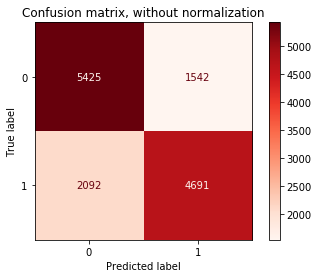

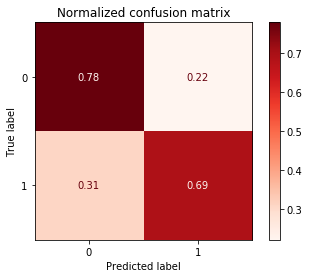

In [27]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import plot_confusion_matrix

target_names=['0', '1']
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None, "0.0f"),
                  ("Normalized confusion matrix", 'true', None)]
for title, normalize, values_format in titles_options:
    disp = plot_confusion_matrix(xgb_best, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize,
                                 values_format=values_format,
                                )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.savefig('XGB {0}.png'.format(title))
    
    
plt.show()

In [28]:
print("Training set score: {:.2f}".format(xgb.score(X_train, y_train)))
print("Test set score: {:.2f}".format(xgb.score(X_test, y_test)))

Training set score: 0.74
Test set score: 0.74


## ROC Curve

In [29]:
# make predicted probabilities for the predictions
# XGBoost classifier
# store the predicted probabilities for class 1 of response

y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]

In [30]:
# the first argument is true values, 
# the second argument is predicted probabilities

# pass y_test and y_pred_prob
# do not use y_pred_class, because it will 
# give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)

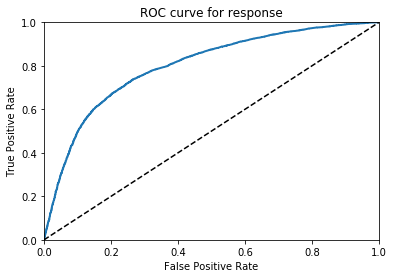

In [31]:
# plot the ROC curve for the gradient boosting classifer
    
plot_roc_curve(fpr, tpr)
plt.savefig('ROC_XGB_plot.pdf')
plt.show()

In [32]:
# evaluate the XGB
# sensitivity and specificity when the threshold is set to 0.5

print('When the threshold is set to 0.5')
evaluate_threshold(0.5)

When the threshold is set to 0.5
Sensitivity: 0.6915818959162613
Specificity: 0.7786708769915315


In [33]:
# AUC is the percentage of the ROC plot that is underneath the curve
# first argument is true values, second argument is predicted probabilities
# AUC for logistic regression, C = 100

roc_auc_y_xgb_class1 = metrics.roc_auc_score(y_test, y_pred_prob_xgb)

print('\nThe AUC is:', roc_auc_y_xgb_class1)


The AUC is: 0.8001460879124753


## XGBoost Feature Importance

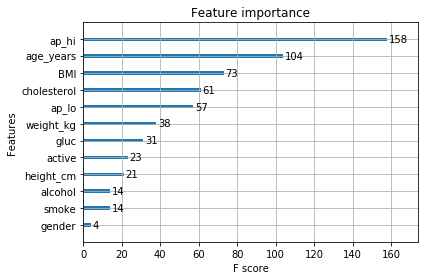

In [34]:
#https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# plot feature importance
from xgboost import plot_importance
plot_importance(xgb)
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')

plt.show()


## XGBoost plot model

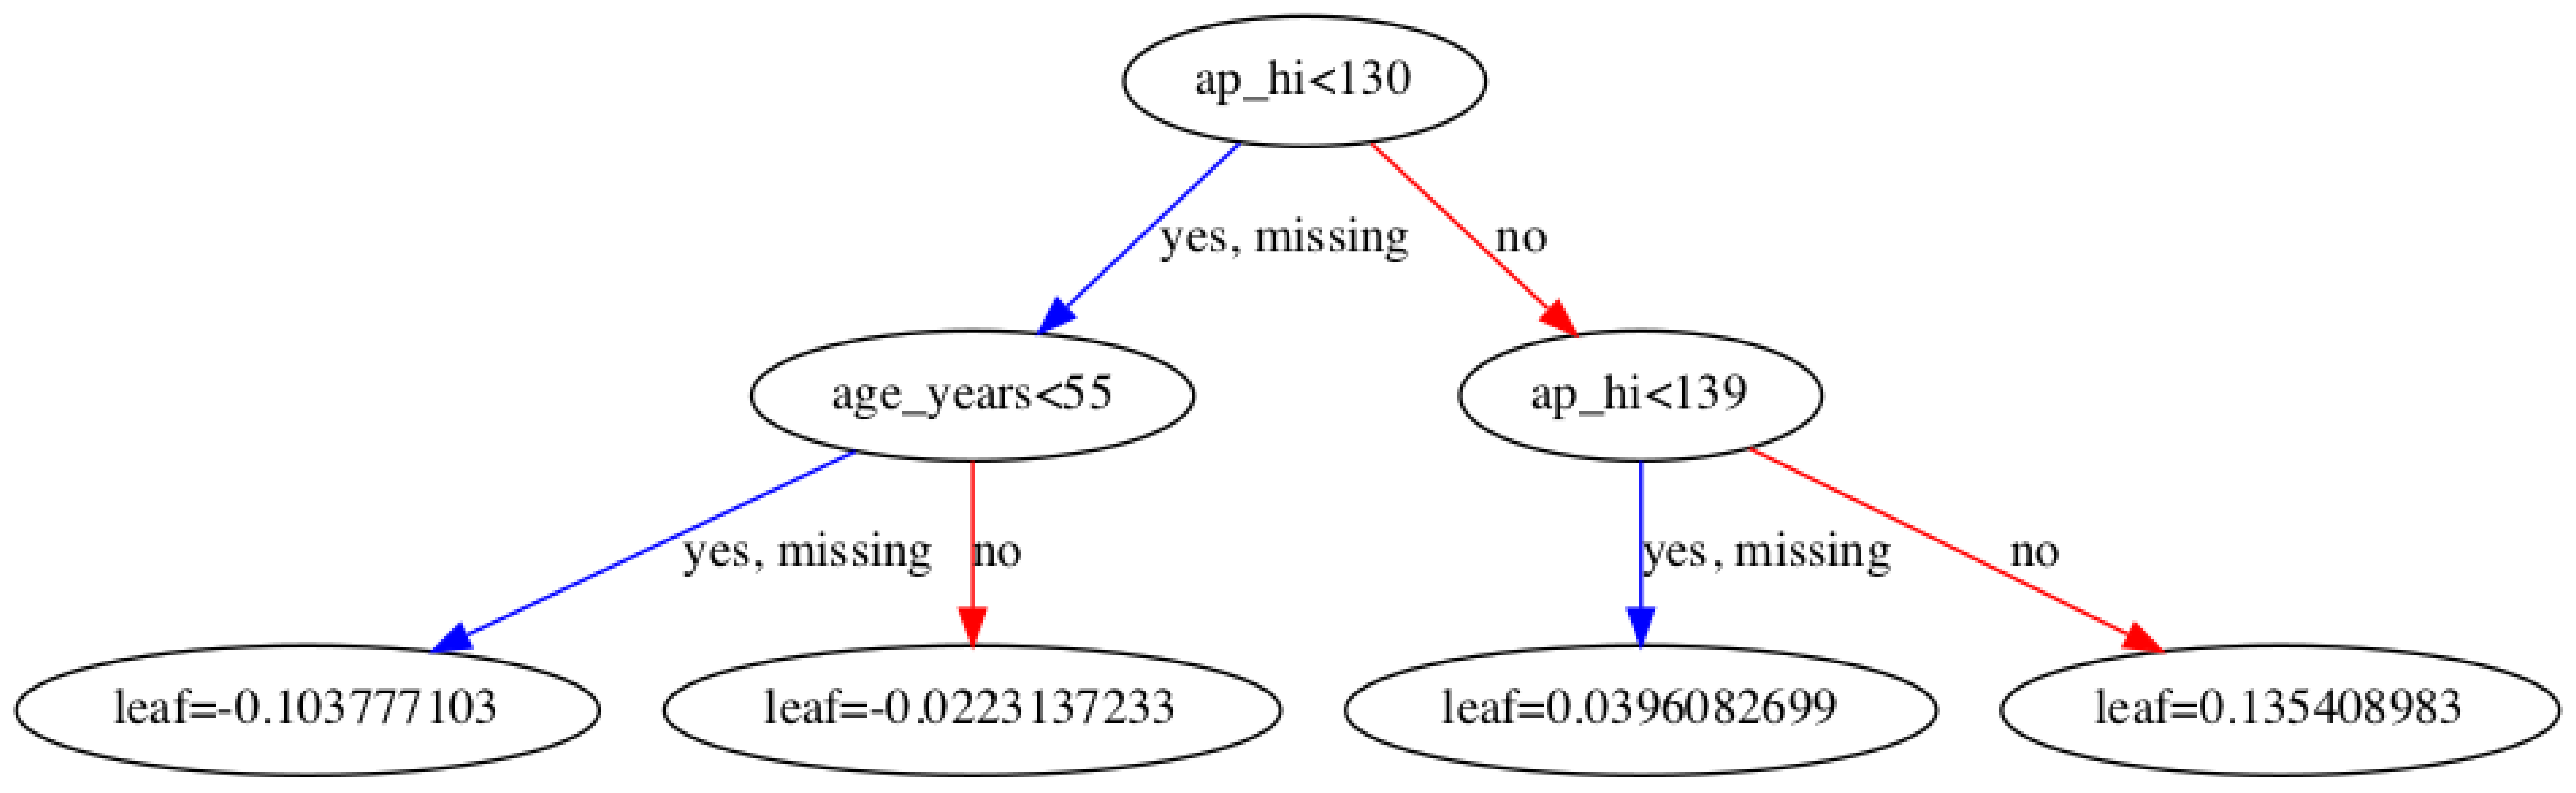

In [35]:
#https://blog.cambridgespark.com/getting-started-with-xgboost-3ba1488bb7d4
from xgboost import plot_tree
import graphviz

#https://stackoverflow.com/questions/51323595/plot-a-single-xgboost-decision-tree/51425835
#https://github.com/dmlc/xgboost/issues/1725
#plt.figure(figsize=(20,15))
plot_tree(xgb, ax=plt.gca())
#plt.savefig("xgboost_tree.pdf")

#this version of the model is visually better
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

Adapted from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/.
For interest, we can test multiple thresholds for selecting features by feature importance. Specifically, the feature importance of each input variable, essentially allowing us to test each subset of features by importance, starting with all features and ending with a subset with the most important feature.

In [39]:
#adapted from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(n_estimators=200, max_depth=2, 
                         learning_rate=0.1, random_state=RANDOM_SEED)
    selection_model.fit(select_X_train, y_train.values.ravel())
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = metrics.accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.006, n=12, Accuracy: 73.57%
Thresh=0.013, n=11, Accuracy: 73.55%
Thresh=0.014, n=10, Accuracy: 73.50%
Thresh=0.018, n=9, Accuracy: 73.53%
Thresh=0.020, n=8, Accuracy: 73.38%
Thresh=0.023, n=7, Accuracy: 73.40%
Thresh=0.027, n=6, Accuracy: 73.32%
Thresh=0.029, n=5, Accuracy: 73.26%
Thresh=0.048, n=4, Accuracy: 73.14%
Thresh=0.135, n=3, Accuracy: 72.68%
Thresh=0.149, n=2, Accuracy: 72.20%
Thresh=0.518, n=1, Accuracy: 71.21%


## Converting the leaf values to meaningful interpretation

In [40]:
import numpy as np
# convert log odds to probability
def odds_to_probs(odds):
    return(np.exp(odds)/ (1 + np.exp(odds)))

#https://stackoverflow.com/questions/40926340/what-does-the-value-of-leaf-in-the-following-xgboost-model-tree-diagram-means
    
    

In [41]:
# probability of leaf 
print(odds_to_probs(-0.103777103))
print(odds_to_probs(-0.0223137233))
print(odds_to_probs(0.03963082699))
print(odds_to_probs(0.135408983))

#the probability of this leaf is class=1
#https://stackoverflow.com/questions/40926340/what-does-the-value-of-leaf-in-the-following-xgboost-model-tree-diagram-means


0.4740789835118278
0.4944218006229133
0.5099064101954305
0.533800615332924


In [ ]:
#same answer as above
1/(1+np.exp(-1*0.135408983))